# Univariate and Multivariate analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from utils import create_date, drop_smart_contract, clean_up_row, drop_missing_data
from data_preparation import train_data_loader, data_pre_processing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
import seaborn as sns

import networkx as nx
import operator

## Load data

In [2]:
data = train_data_loader()

/home/erika/eth_fraud_detection/data_preparation.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_20170702 = pd.read_csv("https://s3.eu-central-2.wasabisys.com/ethblockchain/eth_trans_20170702.csv")
/home/erika/eth_fraud_detection/data_preparation.py:21: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_20170707 = pd.read_csv("https://s3.eu-central-2.wasabisys.com/ethblockchain/eth_trans_20170707.csv")
/home/erika/eth_fraud_detection/data_preparation.py:22: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_20170708 = pd.read_csv("https://s3.eu-central-2.wasabisys.com/ethblockchain/eth_trans_20170708.csv")
/home/erika/eth_fraud_detection/data_preparation.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_20170709 = pd.read_csv("https://s3.eu-central-

# Data Preprocessing

In [3]:
df = data_pre_processing(data)

/home/erika/eth_fraud_detection/utils.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop.drop(columns=['check_hash'], inplace=True)
/home/erika/eth_fraud_detection/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_missing_date.drop(['receipt_status', 'max_fee_per_gas', 'max_priority_fee_per_gas', 'transaction_type','receipt_contract_address'],axis=1,inplace=True)
/home/erika/eth_fraud_detection/utils.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [4]:
!nvidia-smi

Sat Jul 15 15:44:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                 Off| 00000000:3B:00.0 Off |                  Off |
|  0%   34C    P8               26W / 260W|     10MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Drop target features (comments, flags)
train_data = df.drop(['comment_from_address_darklst','date_mal_trans_from', 'mal_trans_from', 'comment_to_address_darklst',
                    'date_mal_trans_to', 'mal_trans_to','transaction_flag1', 'transaction_flag2','attack_descr', 'attack_date'],axis=1)


# Keep only numeric features
train_data = train_data[['nonce', 'transaction_index',
       'value', 'gas', 'gas_price', 'receipt_cumulative_gas_used',
       'receipt_gas_used', 'block_number','receipt_effective_gas_price', 
       'dates', 'gas_price_unit','value_div_gas', 'from_address_count', 'to_address_count',
       'block_count', 'degree_centrality_from', 'degree_centrality_to',
       'in_degree_adr_to', 'out_degree_adr_to', 'in_degree_adr_from','out_degree_adr_from','transaction_flag']]

In [6]:
Xtrain = train_data.drop(['transaction_flag'],axis=1)
Xtrain.set_index('dates', inplace=True)
ytrain = train_data[['transaction_flag','dates']]
ytrain.set_index('dates', inplace=True)

## Univariate analysis

Univariate analisys do not look into all the features collectively, and the interaction between the features is not taken into account. 
The aim of univariate analysis is to look at each feature separately and determine if there is a significant relationship btween the fature and the target

https://towardsdatascience.com/mistakes-in-applying-univariate-feature-selection-methods-34c43ce8b93d

how to select the univariate anlysis to apply:

- Features: continuous, regression : linear regression F-test (f_regression), classification: ANOVA F-test, f_classif
- Features: categorical, regression :  n/a, classification: chi-squared test (chi2)

ANOVA F-test (f_classif)
In statistics, ANOVA is used to determine whether there is any statistically significant difference between the means of two or more groups. This is particularly useful in a classification problem where we want to know how well a continuous feature discriminates between multiple classes.

**ANOVA compares the variation between each species to the variation within each species. By making some statistical assumptions, we can show that the ratio between the two variations follows the F-distribution, which gives us a nice F-score and p-value to evaluate.**

Warning: Remember the “statistical assumptions” I briefly mentioned above? It turns out that ANOVA F-test has a strict requirement that all groups share a common variance (even when their means are different). If your groups have unequal variances, the test can be invalid. The solution to this is to use Welch’s ANOVA, which does not assume that the variances are equal. You can learn more about it here.

1. Correlation between the numberic features and the target variable

<AxesSubplot:>

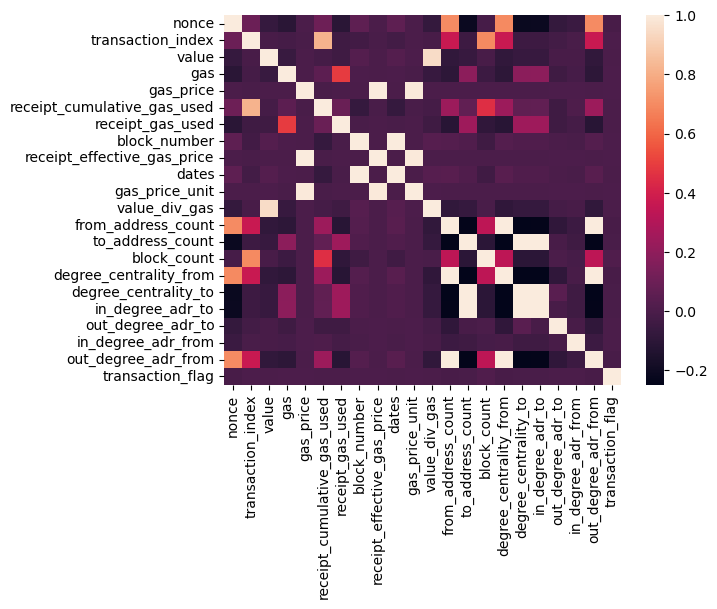

In [7]:
train_data.corr()
sns.heatmap(train_data.corr())

In [8]:
train_data.corr()

,nonce,transaction_index,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,block_number,receipt_effective_gas_price,dates,...,from_address_count,to_address_count,block_count,degree_centrality_from,degree_centrality_to,in_degree_adr_to,out_degree_adr_to,in_degree_adr_from,out_degree_adr_from,transaction_flag
nonce,1.000000,0.097710,-0.070275,-0.108999,-0.004569,0.099484,-0.109521,0.057060,-0.004569,0.057182,...,0.698142,-0.213678,-0.014603,0.696821,-0.217431,-0.213678,-0.075420,-0.057397,0.698142,-0.010043
transaction_index,0.097710,1.000000,-0.011755,-0.023192,-0.005825,0.814815,-0.042134,-0.030552,-0.005825,-0.026817,...,0.367478,-0.047053,0.697014,0.367634,-0.048455,-0.047053,-0.027628,-0.007836,0.367478,0.004735
value,-0.070275,-0.011755,1.000000,-0.059357,-0.000264,-0.021421,-0.039277,0.029435,-0.000264,0.028785,...,-0.082983,-0.065978,-0.010007,-0.083477,-0.066648,-0.065978,-0.013918,-0.010303,-0.082983,-0.001051
gas,-0.108999,-0.023192,-0.059357,1.000000,-0.001270,0.051411,0.490815,0.003838,-0.001270,0.003776,...,-0.099203,0.191136,-0.049050,-0.099996,0.188715,0.191136,-0.043300,-0.017608,-0.099203,0.005034
gas_price,-0.004569,-0.005825,-0.000264,-0.001270,1.000000,-0.007620,-0.002356,-0.000402,1.000000,-0.000366,...,-0.003047,-0.003914,-0.001017,-0.003030,-0.003899,-0.003914,0.000236,0.000540,-0.003047,0.000628
receipt_cumulative_gas_used,0.099484,0.814815,-0.021421,0.051411,-0.007620,1.000000,0.089907,-0.069261,-0.007620,-0.068223,...,0.236320,0.064128,0.450350,0.236835,0.061878,0.064128,-0.042100,0.005860,0.236320,-0.003224
receipt_gas_used,-0.109521,-0.042134,-0.039277,0.490815,-0.002356,0.089907,1.000000,-0.007044,-0.002356,-0.007926,...,-0.112701,0.243724,-0.087893,-0.113736,0.241247,0.243724,-0.043527,-0.023527,-0.112701,-0.004330
block_number,0.057060,-0.030552,0.029435,0.003838,-0.000402,-0.069261,-0.007044,1.000000,-0.000402,0.999285,...,0.029440,0.012725,-0.043102,0.029152,0.012641,0.012725,-0.001409,-0.008530,0.029440,0.000468
receipt_effective_gas_price,-0.004569,-0.005825,-0.000264,-0.001270,1.000000,-0.007620,-0.002356,-0.000402,1.000000,-0.000366,...,-0.003047,-0.003914,-0.001017,-0.003030,-0.003899,-0.003914,0.000236,0.000540,-0.003047,0.000628
dates,0.057182,-0.026817,0.028785,0.003776,-0.000366,-0.068223,-0.007926,0.999285,-0.000366,1.000000,...,0.034800,0.010917,-0.037657,0.034535,0.010826,0.010917,-0.001577,-0.008085,0.034800,0.000123


2. ANOVA - one way ANOVA-f

In [9]:
f_class = f_classif(Xtrain,ytrain)
f_class

/home/erika/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(array([7.52575854e+02, 1.67250461e+02, 8.24326360e+00, 1.89092864e+02,
        2.94494775e+00, 7.75641565e+01, 1.39884149e+02, 1.63575331e+00,
        2.94494775e+00, 3.10420433e-01, 1.83030683e+01, 1.05204878e+03,
        5.91517256e+02, 1.54448951e+03, 1.07451067e+03, 6.13965827e+02,
        5.91517256e+02, 8.39139560e+01, 6.38966328e+01, 1.05204878e+03]),
 array([1.12611554e-165, 2.95211529e-038, 4.09036348e-003, 5.02189439e-043,
        8.61465267e-002, 1.28507215e-018, 2.82381767e-032, 2.00909167e-001,
        8.61465267e-002, 5.77422322e-001, 1.88405815e-005, 9.06057542e-231,
        1.18575182e-130, 0.00000000e+000, 1.19051471e-235, 1.55482421e-135,
        1.18575182e-130, 5.16909125e-020, 1.31140067e-015, 9.06057542e-231]))

In [10]:
f_class[1]
len(f_class[1])
Xtrain.columns

F_test = pd.DataFrame(data=f_class, index=['F-score','pvalue'],columns=Xtrain.columns)
F_test = F_test.T.sort_values(by=['pvalue'], ascending=False)
F_test


,F-score,pvalue
gas_price_unit,0.310420,5.774223e-01
block_number,1.635753,2.009092e-01
gas_price,2.944948,8.614653e-02
receipt_effective_gas_price,2.944948,8.614653e-02
value,8.243264,4.090363e-03
value_div_gas,18.303068,1.884058e-05
in_degree_adr_from,63.896633,1.311401e-15
receipt_cumulative_gas_used,77.564156,1.285072e-18
out_degree_adr_to,83.913956,5.169091e-20
receipt_gas_used,139.884149,2.823818e-32


## Correlation between features

In [11]:
Xtrain.corr()

,nonce,transaction_index,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,block_number,receipt_effective_gas_price,gas_price_unit,value_div_gas,from_address_count,to_address_count,block_count,degree_centrality_from,degree_centrality_to,in_degree_adr_to,out_degree_adr_to,in_degree_adr_from,out_degree_adr_from
nonce,1.000000,0.097710,-0.070275,-0.108999,-0.004569,0.099484,-0.109521,0.057060,-0.004569,-0.003508,-0.073865,0.698142,-0.213678,-0.014603,0.696821,-0.217431,-0.213678,-0.075420,-0.057397,0.698142
transaction_index,0.097710,1.000000,-0.011755,-0.023192,-0.005825,0.814815,-0.042134,-0.030552,-0.005825,-0.004255,-0.009753,0.367478,-0.047053,0.697014,0.367634,-0.048455,-0.047053,-0.027628,-0.007836,0.367478
value,-0.070275,-0.011755,1.000000,-0.059357,-0.000264,-0.021421,-0.039277,0.029435,-0.000264,0.002207,0.946528,-0.082983,-0.065978,-0.010007,-0.083477,-0.066648,-0.065978,-0.013918,-0.010303,-0.082983
gas,-0.108999,-0.023192,-0.059357,1.000000,-0.001270,0.051411,0.490815,0.003838,-0.001270,-0.004901,-0.065632,-0.099203,0.191136,-0.049050,-0.099996,0.188715,0.191136,-0.043300,-0.017608,-0.099203
gas_price,-0.004569,-0.005825,-0.000264,-0.001270,1.000000,-0.007620,-0.002356,-0.000402,1.000000,0.995062,-0.000621,-0.003047,-0.003914,-0.001017,-0.003030,-0.003899,-0.003914,0.000236,0.000540,-0.003047
receipt_cumulative_gas_used,0.099484,0.814815,-0.021421,0.051411,-0.007620,1.000000,0.089907,-0.069261,-0.007620,-0.005400,-0.020547,0.236320,0.064128,0.450350,0.236835,0.061878,0.064128,-0.042100,0.005860,0.236320
receipt_gas_used,-0.109521,-0.042134,-0.039277,0.490815,-0.002356,0.089907,1.000000,-0.007044,-0.002356,-0.003346,-0.041445,-0.112701,0.243724,-0.087893,-0.113736,0.241247,0.243724,-0.043527,-0.023527,-0.112701
block_number,0.057060,-0.030552,0.029435,0.003838,-0.000402,-0.069261,-0.007044,1.000000,-0.000402,-0.000292,0.032140,0.029440,0.012725,-0.043102,0.029152,0.012641,0.012725,-0.001409,-0.008530,0.029440
receipt_effective_gas_price,-0.004569,-0.005825,-0.000264,-0.001270,1.000000,-0.007620,-0.002356,-0.000402,1.000000,0.995062,-0.000621,-0.003047,-0.003914,-0.001017,-0.003030,-0.003899,-0.003914,0.000236,0.000540,-0.003047
gas_price_unit,-0.003508,-0.004255,0.002207,-0.004901,0.995062,-0.005400,-0.003346,-0.000292,0.995062,1.000000,0.002434,-0.004099,-0.004549,-0.001376,-0.004080,-0.004468,-0.004549,0.001482,0.000614,-0.004099


[Text(0.5, 1.0, 'Correlation')]

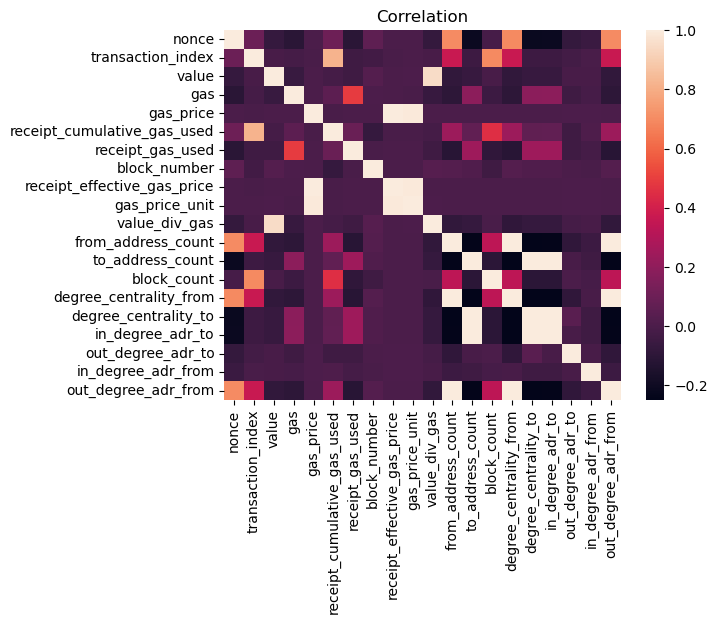

In [12]:
sns.heatmap(Xtrain.corr()).set(title="Correlation")

In [13]:
ytrain['transaction_flag'].value_counts()

transaction_flag
0    7457565
1       3290
Name: count, dtype: int64

In [14]:
Xtrain.columns

Index(['nonce', 'transaction_index', 'value', 'gas', 'gas_price',
       'receipt_cumulative_gas_used', 'receipt_gas_used', 'block_number',
       'receipt_effective_gas_price', 'gas_price_unit', 'value_div_gas',
       'from_address_count', 'to_address_count', 'block_count',
       'degree_centrality_from', 'degree_centrality_to', 'in_degree_adr_to',
       'out_degree_adr_to', 'in_degree_adr_from', 'out_degree_adr_from'],
      dtype='object')

In [15]:
Xtrain.head()

,nonce,transaction_index,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,block_number,receipt_effective_gas_price,gas_price_unit,value_div_gas,from_address_count,to_address_count,block_count,degree_centrality_from,degree_centrality_to,in_degree_adr_to,out_degree_adr_to,in_degree_adr_from,out_degree_adr_from
dates,,,,,,,,,,,,,,,,,,,,
2017-07-31,5,1,0.000000e+00,53759.0,60000000000,74758.0,53758.0,4098983.0,6.000000e+10,1.116092e+06,0.000000e+00,3,4858,171,0.000002,0.003502,4858,0,0,3
2017-07-31,2596723,172,5.459820e+17,50000.0,4000000000,5307522.0,21000.0,4101279.0,4.000000e+09,8.000000e+04,1.091964e+13,357662,32,180,0.257829,0.000046,32,32,6,357662
2017-07-31,2591374,15,2.077429e+17,50000.0,4000000000,336000.0,21000.0,4099488.0,4.000000e+09,8.000000e+04,4.154859e+12,357662,43,93,0.257829,0.000062,43,43,6,357662
2017-07-31,2591369,10,2.178482e+17,50000.0,4000000000,231000.0,21000.0,4099488.0,4.000000e+09,8.000000e+04,4.356964e+12,357662,56,93,0.257829,0.000051,56,15,6,357662
2017-07-31,2591373,14,5.256675e+16,50000.0,4000000000,315000.0,21000.0,4099488.0,4.000000e+09,8.000000e+04,1.051335e+12,357662,60,93,0.257829,0.000044,60,1,6,357662


### Fetaures to drop:

- 'block_number': this is highly correlated with the time stamp, it's deterministaic and doesn't provide any information on the nature of the transaction (as it is predetermined), this could be a candidate to replace the dates
- 'gas price' and with 'receipt_effective_gas_price' : 'gas_price_unit' (Fscore: 0.310420, p-value:5.774223e-01 so null hypostesys is rejected ) is highly correlated with 'gas price' and with 'receipt_effective_gas_price' and has a F-test pvalue that reject the null hypotestys and we would prefer the 'gas_price_unit' as it is more suitable to discriminate between anomalous and non anomalous transactions. 
- 'in_degree_adr_to','degree_centrality_to': 'to_address_count', the correlation is cole to one so the 'to_address_count' 8easiest to interprent has been kept
- 'out_degree_adr_to','degree_centrality_from': 'form_address_count', the correlation is cole to one so the 'from_address_count' 8easiest to interprent has been kept

In [16]:
Xtrain.drop(['block_number','gas_price','receipt_effective_gas_price','in_degree_adr_to','degree_centrality_to', 'out_degree_adr_to','degree_centrality_from','out_degree_adr_from'],axis=1,inplace=True)

[Text(0.5, 1.0, 'Correlation')]

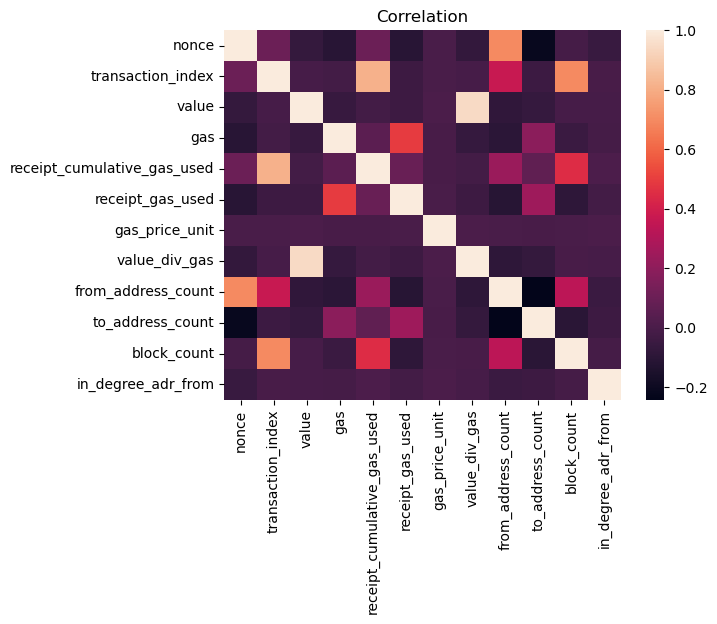

In [17]:
sns.heatmap(Xtrain.corr()).set(title="Correlation")

## Fit the Logistic regression

In [18]:
lr = LogisticRegression(random_state=0).fit(Xtrain,ytrain)
lr.predict(Xtrain)

/home/erika/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/erika/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0])

In [19]:
labels = pd.Series(lr.predict(Xtrain))
pd.unique(labels)
len(pd.unique(labels))

1